In [112]:
%pip install httpx
%pip install pandas
%pip install scipy
%pip install matplotlib
%pip install tables
%pip install xgboost
%pip install scikit-learn
%pip install onnxruntime
%pip install onnxmltools

You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bi

In [196]:
%pip uninstall onnxruntime -q

Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [150]:
import io
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.lines as mlines
from scipy.spatial import transform as scipy_transform

# Helpers

In [5]:
import os

import httpx


class Clickhouse:
    credentials = {
        "user": os.environ['CLICKHOUSE_USER'],
        "password": os.environ['CLICKHOUSE_PASSWORD'],
    }
    url = os.environ['CLICKHOUSE_URL']

    def __init__(self):
        self._httpx_client = httpx.Client()

    def post(
        self,
        query: str,
        headers: dict = None,
        content: bytes = None,
    ) -> str:
        response = self._httpx_client.post(
            url=self.url,
            params={
                "query": query,
                **self.credentials,
            },
            headers=headers,
            content=content,
        )
        return response.text

    def get(
        self,
        query: str,
        headers: dict = None,
    ) -> str:
        response = self._httpx_client.get(
            url=self.url,
            params={
                "query": query,
                **self.credentials,
            },
            headers=headers,
        )
        return response.text


# Load Data

In [6]:
df = None
try:
    df = pd.read_hdf('./data/dataset_gross_prod.h5')
except FileNotFoundError:
    pass

In [7]:
if df is None:
    ch = Clickhouse()
    pos_csv_str = ch.get('SELECT * FROM raw_data FORMAT CSV')
    print(pos_csv_str[:200])

In [8]:
if df is None:
    df = pd.read_csv(
        io.StringIO(pos_csv_str),
        names=[
            'game_result_id', 'game_id', 'patient_id', 'exercise_id', 'timestamp', 'src', 
            'side', 'h_rssi', 'h_gain', 'g_rssi', 'g_gain', 'forearm_quat_x',
            'forearm_quat_y', 'forearm_quat_z', 'forearm_quat_w', 'forearm_lia_x',
            'forearm_lia_y', 'forearm_lia_z', 'forearm_grv_x', 'forearm_grv_y',
            'forearm_grv_z', 'forearm_tilt', 'shoulder_quat_x', 'shoulder_quat_y',
            'shoulder_quat_z', 'shoulder_quat_w', 'shoulder_lia_x',
            'shoulder_lia_y', 'shoulder_lia_z', 'shoulder_grv_x', 'shoulder_grv_y',
            'shoulder_grv_z', 'shoulder_tilt', 'position_type'
        ],
    )
    df.to_hdf('./data/dataset_gross_prod.h5', key='df', mode='w')

# Discover data

In [9]:
df.head(5)

,game_result_id,game_id,patient_id,exercise_id,timestamp,src,side,h_rssi,h_gain,g_rssi,...,shoulder_quat_z,shoulder_quat_w,shoulder_lia_x,shoulder_lia_y,shoulder_lia_z,shoulder_grv_x,shoulder_grv_y,shoulder_grv_z,shoulder_tilt,position_type
0,13601,12,245,7,1997-07-18 12:20:34,00:00:00:00:00:00,1,-99,0,0,...,-0.228246,0.070393,-0.014,0.017,0.018,-6.997,-5.258,-4.470,0.191756,0
1,13601,12,245,7,1997-07-18 12:20:50,00:00:00:00:00:00,1,-99,0,0,...,-0.227818,0.070692,-0.062,0.030,0.024,-7.035,-5.219,-4.470,0.191148,0
2,13601,12,245,7,1997-07-18 12:21:06,00:00:00:00:00:00,1,-99,0,0,...,-0.227661,0.070765,-0.042,0.027,0.038,-7.035,-5.239,-4.479,0.191218,0
3,13601,12,245,7,1997-07-18 12:21:23,00:00:00:00:00:00,1,-99,0,0,...,-0.227546,0.070798,-0.077,0.003,0.052,-7.058,-5.209,-4.508,0.191276,0
4,13601,12,245,7,1997-07-18 12:21:40,00:00:00:00:00:00,1,-99,0,0,...,-0.227546,0.070815,0.046,-0.028,0.084,-6.997,-5.317,-4.546,0.191220,0


In [10]:
df.describe()

,game_result_id,game_id,patient_id,exercise_id,side,h_rssi,h_gain,g_rssi,g_gain,forearm_quat_x,...,shoulder_quat_z,shoulder_quat_w,shoulder_lia_x,shoulder_lia_y,shoulder_lia_z,shoulder_grv_x,shoulder_grv_y,shoulder_grv_z,shoulder_tilt,position_type
count,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000,863299.0,863299.0,863299.0,863299.000000,...,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000
mean,13442.891714,12.175150,517.238543,7.429206,1.404151,-28.875167,0.0,0.0,0.0,0.616545,...,0.018149,0.214336,-0.036779,0.008903,0.016551,-5.371928,-4.540476,-4.403008,0.213721,0.005067
std,134.858963,1.093332,136.433902,0.494963,0.490727,44.998540,0.0,0.0,0.0,0.270717,...,0.309927,0.575343,0.355576,0.366457,0.461615,2.916112,2.786076,3.451149,0.403846,0.091539
min,13237.000000,12.000000,231.000000,7.000000,1.000000,-99.000000,0.0,0.0,0.0,0.000000,...,-0.729122,-0.999874,-12.082000,-12.135000,-13.864000,-20.421000,-19.924000,-18.114000,-0.746533,0.000000
25%,13318.000000,12.000000,377.000000,7.000000,1.000000,-99.000000,0.0,0.0,0.0,0.433823,...,-0.144654,-0.164004,-0.153000,-0.119000,-0.069000,-7.488000,-6.619000,-7.782000,0.000000,0.000000
50%,13461.000000,12.000000,588.000000,7.000000,1.000000,0.000000,0.0,0.0,0.0,0.678424,...,0.048455,0.352448,-0.027000,0.006000,0.007000,-6.426000,-5.147000,-3.917000,0.000000,0.000000
75%,13576.000000,12.000000,614.000000,8.000000,2.000000,0.000000,0.0,0.0,0.0,0.832759,...,0.248513,0.724787,0.084000,0.132000,0.098000,-3.109000,-2.853000,-1.760000,0.228439,0.000000
max,13633.000000,19.000000,618.000000,8.000000,2.000000,0.000000,0.0,0.0,0.0,0.999725,...,0.675516,0.999365,9.048000,18.333000,14.091000,10.376000,11.318000,11.348000,1.570251,2.000000


In [11]:
print(f"{len(df['patient_id'].unique())} patients, {len(df['game_result_id'].unique())} game results")

9 patients, 85 game results


# Calc angle features

In [12]:
def calc_ang_to_Y(row):
    w, x, y, z = row.to_list()
    rotation = scipy_transform.Rotation.from_quat([x, y, z, w])
    vec = rotation.apply([0, 1, 0])
    rad_angle = np.arcsin(vec[2])
    deg_angle = math.degrees(rad_angle)
    return -deg_angle

In [13]:
forearm_quat = [
    'forearm_quat_x', 
    'forearm_quat_y', 
    'forearm_quat_z', 
    'forearm_quat_w',
]
df['forearm_y_ang'] = df[forearm_quat].apply(calc_ang_to_Y, axis=1)
df['forearm_y_ang'].head(5)

0   -27.104250
1   -27.170934
2   -27.175137
3   -27.175137
4   -27.178614
Name: forearm_y_ang, dtype: float64

<AxesSubplot:>

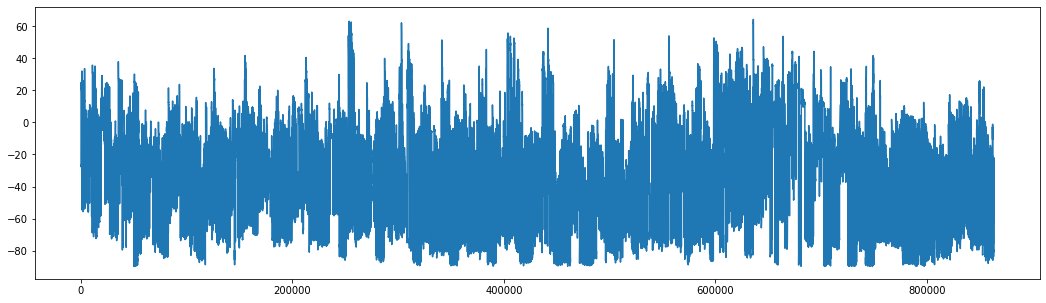

In [14]:
df['forearm_y_ang'].plot(figsize=(18, 5))

In [15]:
shoulder_quat = [
    'shoulder_quat_x',
    'shoulder_quat_y',
    'shoulder_quat_z',
    'shoulder_quat_w',
]
df['shoulder_y_ang'] = df[shoulder_quat].apply(calc_ang_to_Y, axis=1)
df['shoulder_y_ang'].head(5)

0   -10.986856
1   -10.951979
2   -10.955979
3   -10.959384
4   -10.956140
Name: shoulder_y_ang, dtype: float64

<AxesSubplot:>

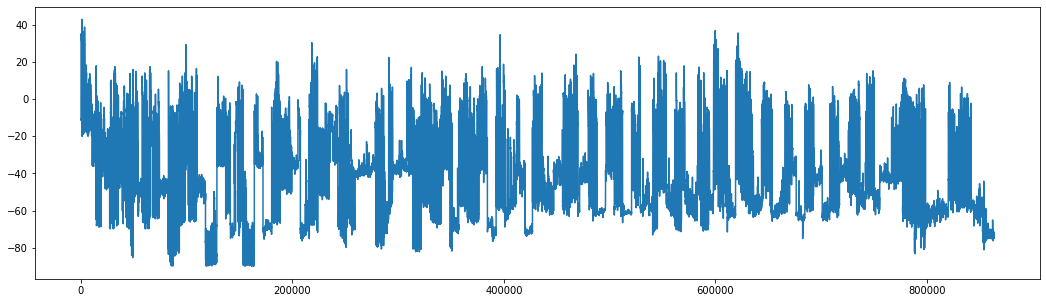

In [16]:
df['shoulder_y_ang'].plot(figsize=(18, 5))

In [17]:
def calc_forearm_shoulder_ang(row):    
    forearm_rotation = scipy_transform.Rotation.from_quat(row.to_list()[:4])
    shoulder_rotation = scipy_transform.Rotation.from_quat(row.to_list()[4:])
    forearm_vec = forearm_rotation.apply([0, 1, 0])
    shoulder_vec = shoulder_rotation.apply([0, 1, 0])
    dot_product = np.dot(forearm_vec / np.linalg.norm(forearm_vec),
                         shoulder_vec / np.linalg.norm(shoulder_vec))
    rad_angle = np.arccos(dot_product)
    deg_angle = math.degrees(rad_angle)
    return deg_angle

In [18]:
forearm_shoulder_quats = [
    'forearm_quat_x', 
    'forearm_quat_y', 
    'forearm_quat_z', 
    'forearm_quat_w',
    'shoulder_quat_x', 
    'shoulder_quat_y', 
    'shoulder_quat_z', 
    'shoulder_quat_w',
]
df['forearm_shoulder_ang'] = df[forearm_shoulder_quats].apply(
    calc_forearm_shoulder_ang, 
    axis=1
)
df['forearm_shoulder_ang'].head(5)

0    15.963966
1    15.967931
2    15.962383
3    15.956629
4    15.953317
Name: forearm_shoulder_ang, dtype: float64

<AxesSubplot:>

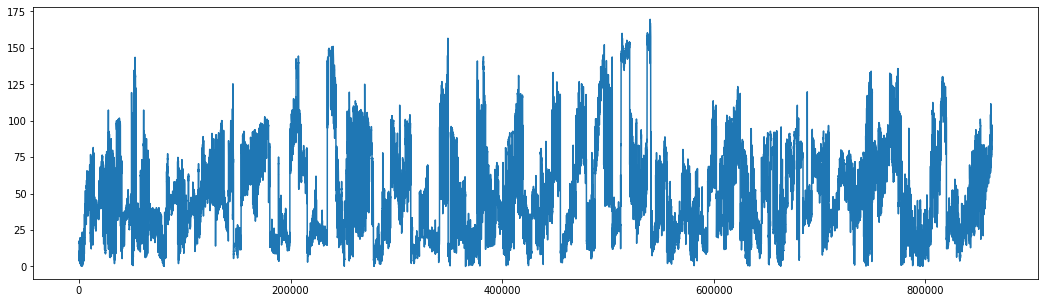

In [19]:
df['forearm_shoulder_ang'].plot(figsize=(18, 5))

# Calc lia features

<AxesSubplot:>

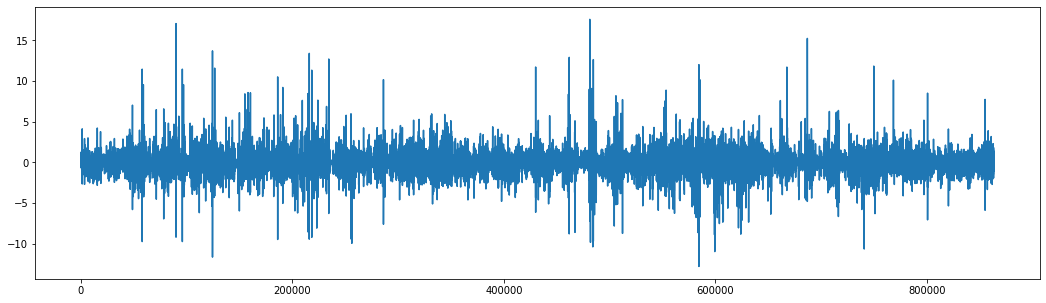

In [20]:
df['forearm_lia_x'] = df['forearm_lia_x'][abs(df['forearm_lia_x']) < 25]
df['forearm_lia_x'].plot(figsize=(18, 5))

<AxesSubplot:>

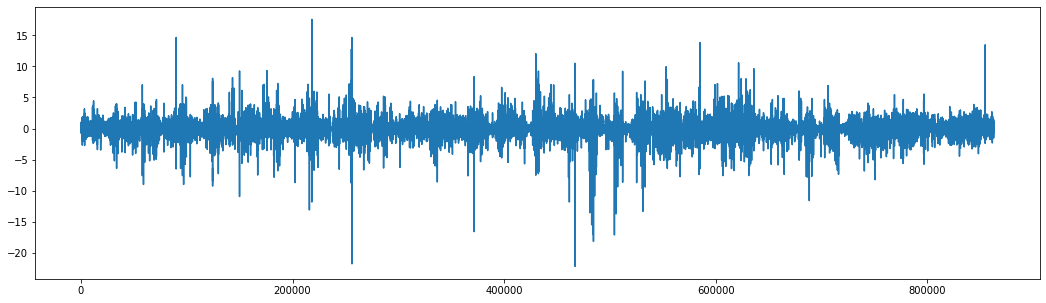

In [21]:
df['forearm_lia_y'] = df['forearm_lia_y'][abs(df['forearm_lia_y']) < 25]
df['forearm_lia_y'].plot(figsize=(18, 5))

<AxesSubplot:>

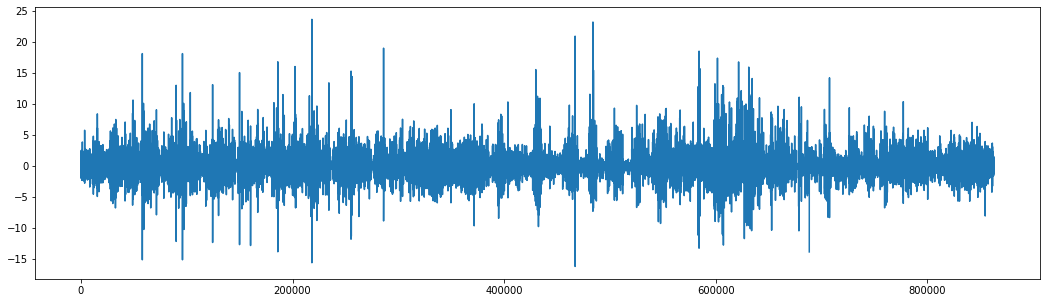

In [22]:
df['forearm_lia_z'] = df['forearm_lia_z'][abs(df['forearm_lia_z']) < 25]
df['forearm_lia_z'].plot(figsize=(18, 5))

<AxesSubplot:>

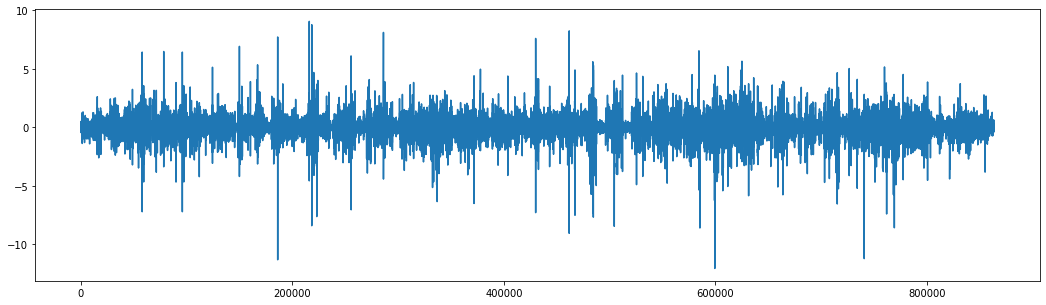

In [23]:
df['shoulder_lia_x'] = df['shoulder_lia_x'][abs(df['shoulder_lia_x']) < 25]
df['shoulder_lia_x'].plot(figsize=(18, 5))

<AxesSubplot:>

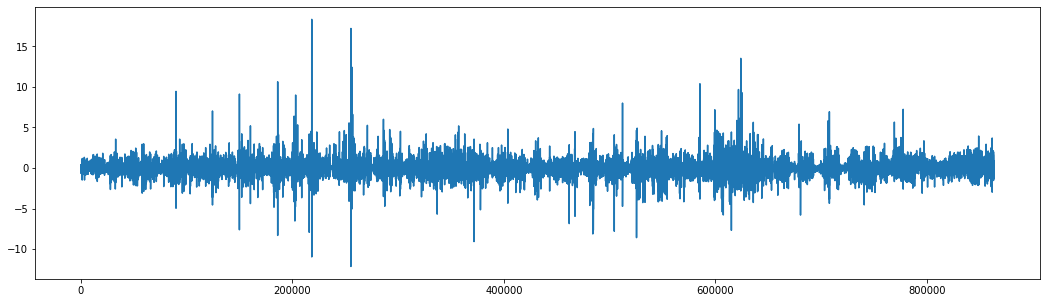

In [24]:
df['shoulder_lia_y'] = df['shoulder_lia_y'][abs(df['shoulder_lia_y']) < 25]
df['shoulder_lia_y'].plot(figsize=(18, 5))

<AxesSubplot:>

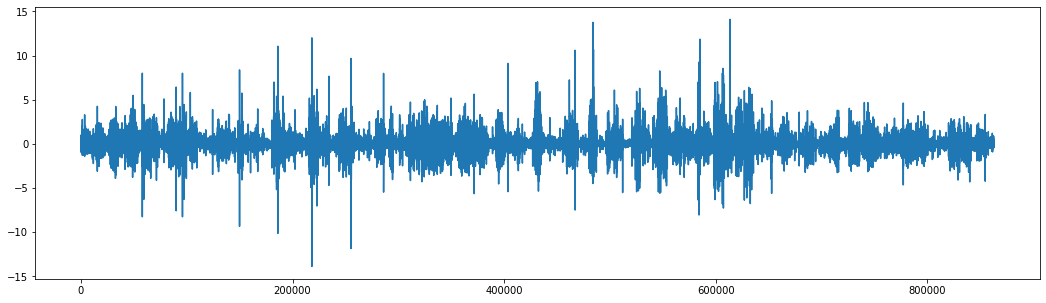

In [25]:
df['shoulder_lia_z'] = df['shoulder_lia_z'][abs(df['shoulder_lia_z']) < 25]
df['shoulder_lia_z'].plot(figsize=(18, 5))

# Discover game sessions

In [26]:
def plot_game_result(result_id, frame_range=(0, -1), save=False, positionType = None, new_figure=True):
    defprops = {
        'xdata': [],
        'ydata': [],
        'linestyle': 'None',
        'markersize': 10
    }
    black_arrow = mlines.Line2D(
        **defprops,
        marker='^',
        color='black',
        label='start position',
    )
    red_arrow = mlines.Line2D(
        **defprops,
        marker='v',
        color='red',
        label='end position',
    )
    plt.legend(handles=[black_arrow, red_arrow])

    result_df = df.loc[df['game_result_id'] == result_id].reset_index(drop=True)
    result_df = result_df.iloc[frame_range[0]:frame_range[1]]

    assert len(exercise_ids := result_df['exercise_id'].unique()) == 1
    assert len(patient_ids := result_df['patient_id'].unique()) == 1
    assert len(game_ids := result_df['game_id'].unique()) == 1
    exercise_id = exercise_ids[0]
    patient_id = patient_ids[0]
    game_id = game_ids[0]

    # 'ArrowDown' positionType = 1;
    start_mark_locs = result_df.loc[result_df['position_type'] == 1].index
    # 'ArrowUp' positionType = 2;
    end_mark_locs = result_df.loc[result_df['position_type'] == 2].index    
    
    if frame_range:
        start_mark_locs = [i - frame_range[0] for i in start_mark_locs]
        end_mark_locs = [i - frame_range[0] for i in end_mark_locs]

    result_df['forearm_y_ang'].plot(
        title=f'patient {patient_id}, result {result_id}, exercise {exercise_id}, game {game_id}',
        figsize=(25, 6),
        color='tab:blue',
        marker='^',
        markersize=10,
        markerfacecolor='black',
        markevery=start_mark_locs,
    )
    ax = result_df['forearm_y_ang'].plot(
        figsize=(25, 6),
        color='tab:blue',
        marker='v',
        markersize=10,
        markerfacecolor='red',
        markevery=end_mark_locs,
    )
    if save:
        fig = ax.get_figure()
        path = (
            (f'./charts/p{patient_id}_r{result_id}_e{exercise_id}') +
            (f'_{frame_range[0]}_{frame_range[1]}' if frame_range != (0, -1) else '') + 
            (f'_{positionType}' if positionType else '')
        )
        fig.savefig(path, facecolor='#FFFFFF') 
    if new_figure:
        plt.figure()


In [27]:
def plot_game_sessions(patient_id, save=False):
    patient_df = df.loc[df['patient_id'] == patient_id]
    result_ids = patient_df['game_result_id'].unique()
    print(result_ids)
    for result_id in result_ids:
        plot_game_result(result_id, save=save)

In [28]:
PATIENT_IDS = sorted(df['patient_id'].unique())
PATIENT_IDS

[231, 245, 377, 552, 588, 594, 612, 614, 618]

In [29]:
GAME_RESULT_IDS = sorted(df['game_result_id'].unique())
GAME_RESULT_IDS

[13237,
 13238,
 13239,
 13240,
 13241,
 13242,
 13243,
 13244,
 13245,
 13246,
 13247,
 13248,
 13249,
 13253,
 13254,
 13270,
 13273,
 13276,
 13278,
 13280,
 13282,
 13289,
 13318,
 13319,
 13320,
 13325,
 13371,
 13373,
 13387,
 13389,
 13391,
 13393,
 13394,
 13395,
 13396,
 13397,
 13439,
 13440,
 13441,
 13442,
 13458,
 13459,
 13460,
 13461,
 13475,
 13477,
 13478,
 13479,
 13486,
 13487,
 13495,
 13496,
 13497,
 13498,
 13504,
 13505,
 13506,
 13507,
 13513,
 13514,
 13515,
 13562,
 13563,
 13575,
 13576,
 13577,
 13578,
 13586,
 13589,
 13590,
 13591,
 13601,
 13604,
 13612,
 13613,
 13614,
 13615,
 13622,
 13624,
 13625,
 13627,
 13630,
 13631,
 13632,
 13633]

[13270]


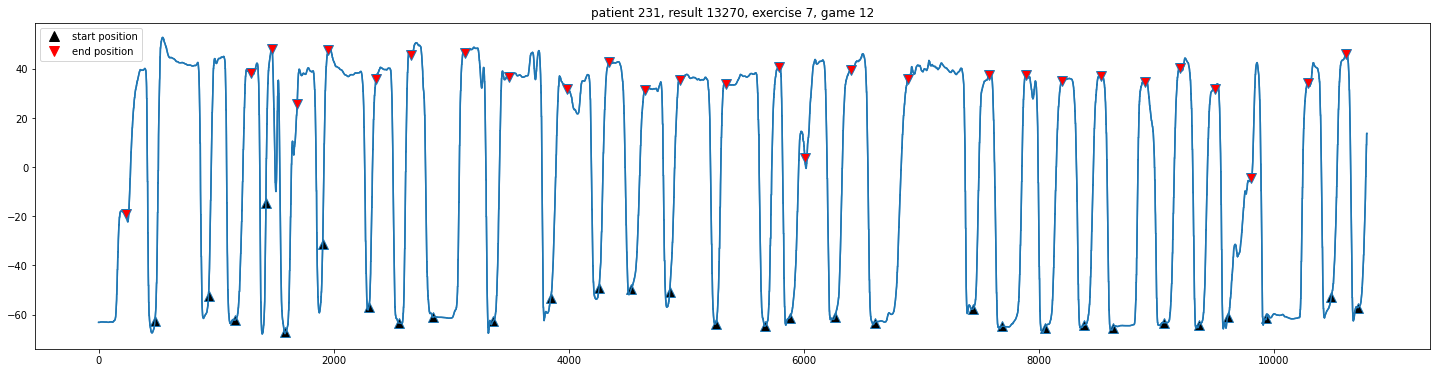

<Figure size 432x288 with 0 Axes>

In [30]:
# Others game sessions looks similar 
for patient_id in PATIENT_IDS[:1]:
    plot_game_sessions(patient_id)

# Hypothesis 1
The model will work precicely, if it will have rolling windows based features that capture the "corner" of amplitude change or zone includes both sharp change of a sensor's angle to the Y axis, then moment where the angle stops to change sharply and then relatively flat zone. 

In [31]:
def get_mark_locs(studied_result_id):
    result_df = df.loc[df['game_result_id'] == studied_result_id].reset_index(drop=True)
    # 'ArrowDown' positionType = 1;
    start_mark_locs = result_df.loc[result_df['position_type'] == 1].index
    # 'ArrowUp' positionType = 2;
    end_mark_locs = result_df.loc[result_df['position_type'] == 2].index   
    return start_mark_locs, end_mark_locs  

In [32]:
def plot_samples(result_id):
    start_mark_locs, end_mark_locs = get_mark_locs(result_id)
    plt.figure()
    for mark_loc in start_mark_locs:
        frame_range = (max(0, mark_loc - 55), mark_loc + 15)
        plot_game_result(result_id, frame_range, save=True, positionType='start', new_figure=False)
    plt.figure()
    for mark_loc in end_mark_locs:
        frame_range = (max(0, mark_loc - 55), mark_loc + 15)
        plot_game_result(result_id, frame_range, save=True, positionType='end', new_figure=False)

## Windows size detection

In [33]:
studied_patient_id = PATIENT_IDS[4]
studied_patient_id

588

In [34]:
result_ids = df.loc[df['patient_id'] == studied_patient_id]['game_result_id'].unique()
result_ids

array([13237, 13238, 13239, 13240, 13241, 13242, 13439, 13440, 13441,
       13442, 13562, 13563])

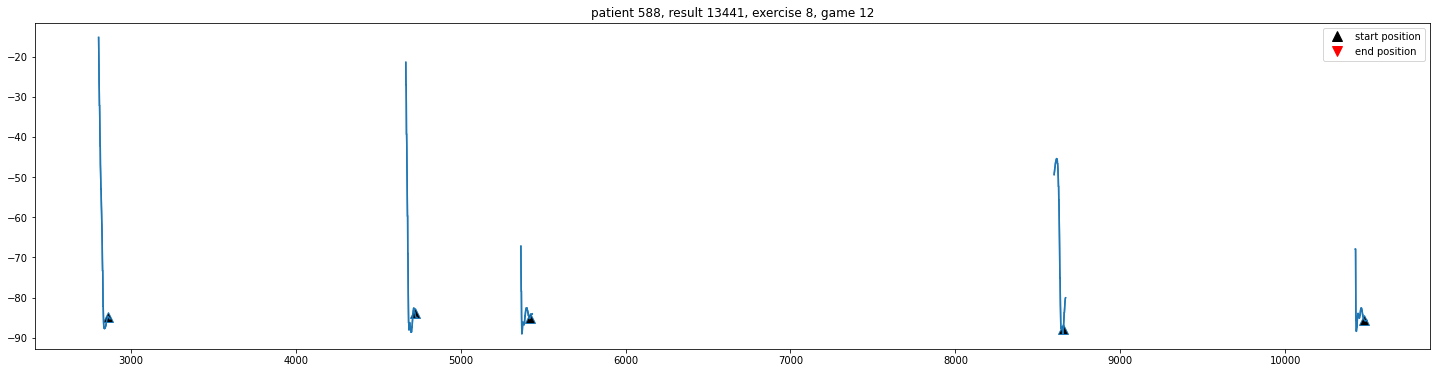

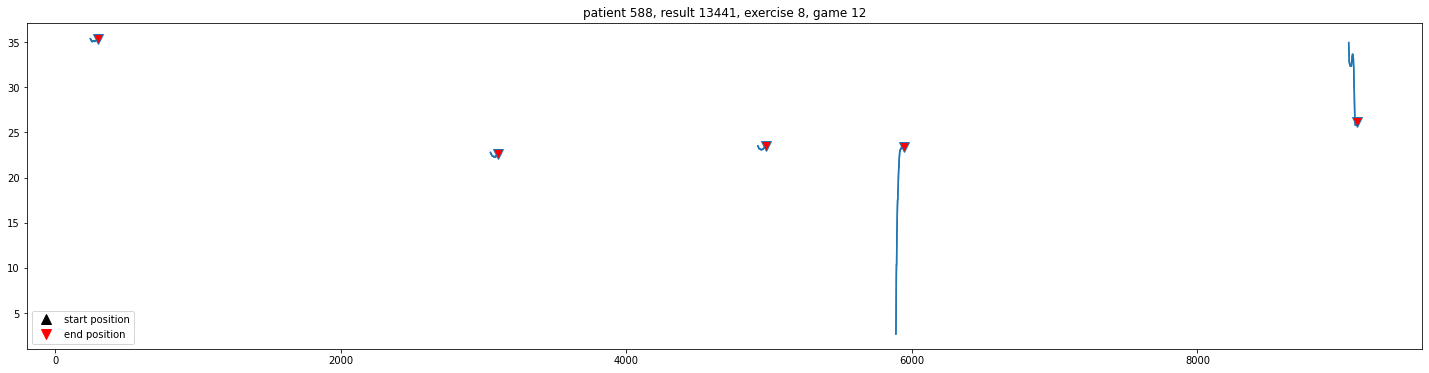

In [35]:
plot_samples(result_ids[8])

In [36]:
OPTIMAL_WINDOW_SIZE = 70

## Data labeling
Optimal window size is 70

In [37]:
def mark_ranges():    
    df['position_type_window'] = 0

    # 'ArrowDown' positionType = 1;
    start_mark_locs = df.loc[df['position_type'] == 1].index
    # 'ArrowUp' positionType = 2;
    end_mark_locs = df.loc[df['position_type'] == 2].index   

    for mark_loc in start_mark_locs:
        df.loc[max(mark_loc - 55, 0): mark_loc + 15, 'position_type_window'] = 1
    for mark_loc in end_mark_locs:
        df.loc[max(mark_loc - 55, 0): mark_loc + 15, 'position_type_window'] = 2


In [38]:
mark_ranges()
df['position_type_window'].head(5)

0    0
1    0
2    0
3    0
4    0
Name: position_type_window, dtype: int64

In [39]:
def plot_mark_ranges(result_id):
    result_df = df.loc[df['game_result_id'] == result_id].reset_index(drop=True)
    # result_df = result_df.iloc[0:2500]

    patient_ids = result_df['patient_id'].unique()
    assert len(patient_ids) == 1
    patient_id = patient_ids[0]
    
    # 'ArrowDown' positionType = 1;
    start_mark_locs = result_df.loc[result_df['position_type_window'] == 1].index
    # 'ArrowUp' positionType = 2;
    end_mark_locs = result_df.loc[result_df['position_type_window'] == 2].index  

    result_df['forearm_y_ang'].plot(
        title=f'patient {patient_id}, result {result_id}',
        figsize=(25, 6),
        color='tab:blue',
        marker='o',
        markeredgewidth=0,
        markersize=5,
        markerfacecolor='black',
        markevery=start_mark_locs,
    )
    result_df['forearm_y_ang'].plot(
        figsize=(25, 6),
        color='tab:blue',
        marker='o',
        markeredgewidth=0,
        markersize=5,
        markerfacecolor='red',
        markevery=end_mark_locs,
    )
    plt.figure()


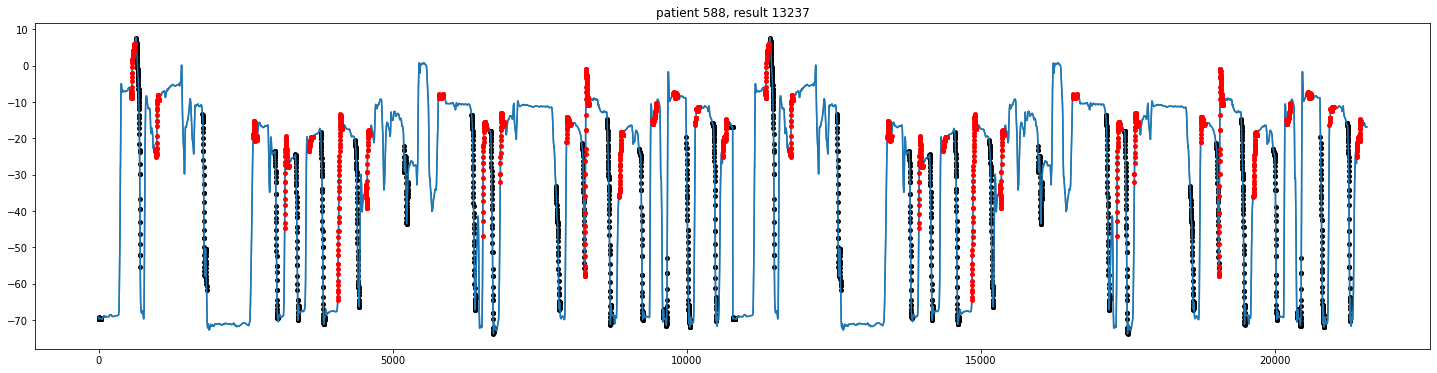

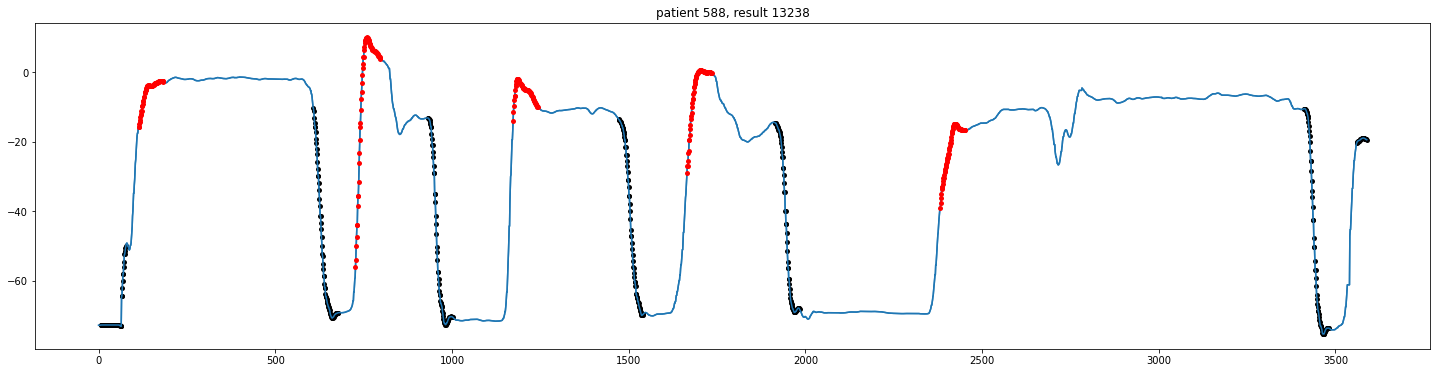

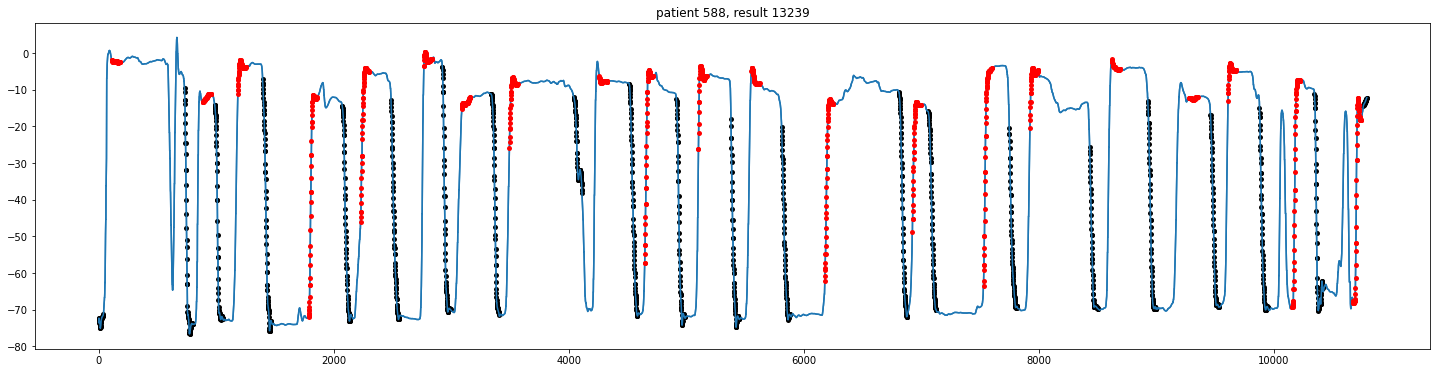

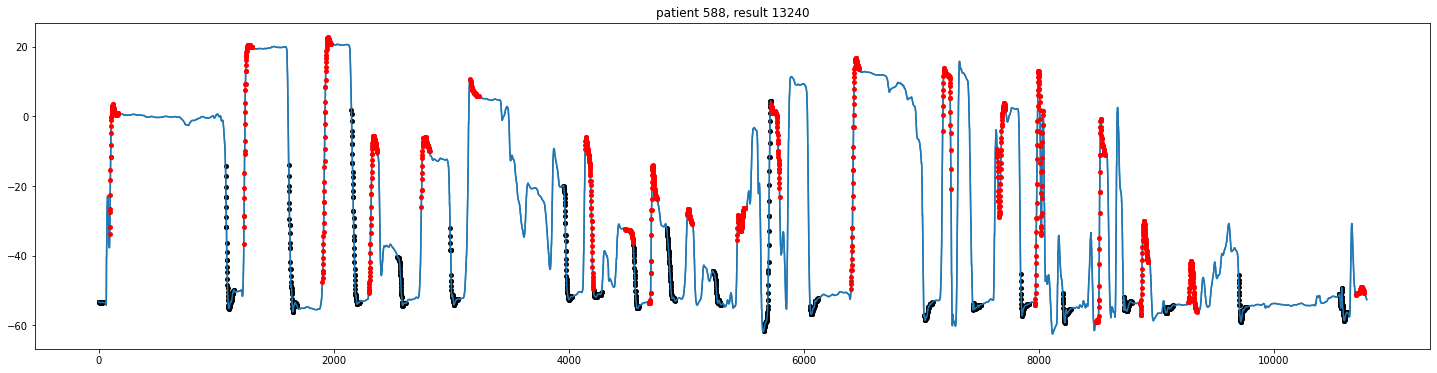

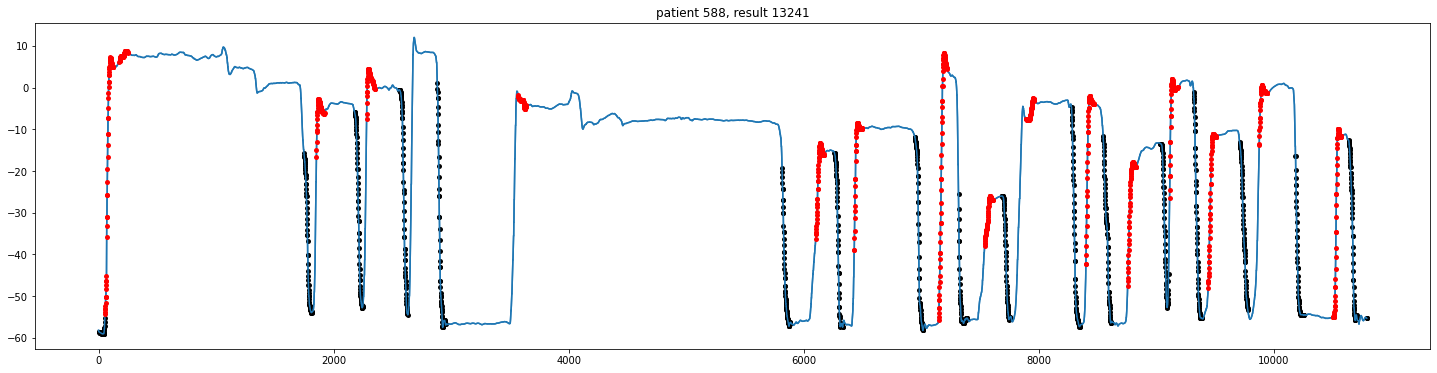

<Figure size 432x288 with 0 Axes>

In [40]:
for result_id in GAME_RESULT_IDS[:5]:
    plot_mark_ranges(result_id)

## Feature Extration

**Discrete:**
- ~~Угол между 2-мя датчиками~~
- ~~Разность между текущим углом и углом между сенсорами в предыдущем распознанном исходном положении~~
- ~~Разность между текущим и средним углом между сенсорами~~

**Window based:**
- ~~forearm_y_ang_rolling_10_mean~~
- ~~forearm_shoulder_ang_rolling_10_mean~~
- ~~forearm_y_ang_rolling_130_std~~
- ~~forearm_shoulder_ang_rolling_130_std~~
- ~~forearm_y_ang_rolling_100_min~~
- ~~forearm_y_ang_rolling_100_max~~
- ~~forearm_y_ang_rolling_20_diff_curr_max~~
- ~~forearm_y_ang_rolling_20_diff_curr_min~~
- ~~forearm_y_ang_mean_rolling_130_diff_max_rolling_130~~
- ~~forearm_y_ang_mean_rolling_130_diff_min_rolling_130~~
- ~~forearm_y_ang_median_rolling_130~~
----------------------------------------------------------------------------
- Фичи волатильноти сигнала
- Количество переходов через 0 угловой скорости (смена знака скорости означает смену направления движения руки) за N предшествующих фреймов
- Количество и частота пиков угла между датчиками за N предшествующих фреймов



In [41]:
import random

def plot_feature(name):
    plot_num = 10
    start_range = random.randint(0, len(GAME_RESULT_IDS) - plot_num)
    end_range = plot_num + start_range 
    for result_id in GAME_RESULT_IDS[start_range:end_range]:
        result_df = df.loc[df['game_result_id'] == result_id].reset_index(drop=True)
        # result_df = result_df.iloc[0:2500]

        patient_ids = result_df['patient_id'].unique()
        assert len(patient_ids) == 1
        patient_id = patient_ids[0]
        
        # 'ArrowDown' positionType = 1;
        start_mark_locs = result_df.loc[result_df['position_type_window'] == 1].index
        # 'ArrowUp' positionType = 2;
        end_mark_locs = result_df.loc[result_df['position_type_window'] == 2].index  

        result_df[name].plot(
            title=f'feature: {name}, patient: {patient_id}, result: {result_id}',
            figsize=(25, 6),
            color='tab:blue',
            marker='o',
            markeredgewidth=0,
            markersize=5,
            markerfacecolor='black',
            markevery=start_mark_locs,
        )
        result_df[name].plot(
            figsize=(25, 6),
            color='tab:blue',
            marker='o',
            markeredgewidth=0,
            markersize=5,
            markerfacecolor='red',
            markevery=end_mark_locs,
        )
        plt.figure()


### forearm_y_ang_rolling_10_mean

In [42]:
df['forearm_y_ang_rolling_10_mean'] = df['forearm_y_ang'].rolling(10).mean()

In [43]:
# plot_feature('forearm_y_ang_rolling_10_mean')

### shoulder_y_ang_rolling_10_mean

In [44]:
df['shoulder_y_ang_rolling_10_mean'] = df['shoulder_y_ang'].rolling(10).mean()

In [45]:
# plot_feature('shoulder_y_ang_rolling_10_mean')

### forearm_shoulder_ang_rolling_10_mean

In [46]:
df['forearm_shoulder_ang_rolling_10_mean'] = df['forearm_shoulder_ang'].rolling(10).mean()

In [47]:
# plot_feature('forearm_shoulder_ang_rolling_10_mean')

### forearm_direction

In [48]:
df['forearm_direction'] = df['forearm_y_ang_rolling_10_mean'] - df['forearm_y_ang_rolling_10_mean'].shift(1)
# plot_feature('forearm_direction')

### shoulder_direction

In [49]:
df['shoulder_direction'] = df['shoulder_y_ang_rolling_10_mean'] - df['shoulder_y_ang_rolling_10_mean'].shift(1)
# plot_feature('shoulder_direction')

### forearm_shoulder_direction

In [50]:
df['forearm_shoulder_direction'] = df['forearm_shoulder_ang_rolling_10_mean'] - df['forearm_shoulder_ang_rolling_10_mean'].shift(1)
# plot_feature('forearm_shoulder_direction')

### forearm_y_ang_rolling_130_std_directed

In [51]:
df['forearm_y_ang_rolling_130_std_directed'] = df['forearm_y_ang'].rolling(130).std() * np.sign(df['forearm_direction'])
# plot_feature('forearm_y_ang_rolling_130_std_directed')

### shoulder_y_ang_rolling_130_std

In [52]:
df['shoulder_y_ang_rolling_130_std_directed'] = df['shoulder_y_ang'].rolling(130).std() * np.sign(df['shoulder_direction'])

In [53]:
# plot_feature('shoulder_y_ang_rolling_130_std_directed')

### forearm_shoulder_ang_rolling_130_std_directed

In [54]:
df['forearm_shoulder_ang_rolling_130_std_directed'] = df['forearm_shoulder_ang'].rolling(130).std() * np.sign(df['forearm_shoulder_direction'])

In [55]:
# plot_feature('forearm_shoulder_ang_rolling_130_std_directed')

### forearm_y_ang_rolling_100_min

In [56]:
df['forearm_y_ang_rolling_100_min'] = df['forearm_y_ang'].rolling(100).min()

In [57]:
# plot_feature('forearm_y_ang_rolling_100_min')

### forearm_shoulder_ang_rolling_100_min

In [58]:
df['forearm_shoulder_ang_rolling_100_min'] = df['forearm_shoulder_ang'].rolling(100).min()

In [59]:
# plot_feature('forearm_shoulder_ang_rolling_100_min')

### shoulder_y_ang_rolling_100_min

In [60]:
df['shoulder_y_ang_rolling_100_min'] = df['shoulder_y_ang'].rolling(100).min()

In [61]:
# plot_feature('shoulder_y_ang_rolling_100_min')

### forearm_y_ang_rolling_100_max

In [62]:
df['forearm_y_ang_rolling_100_max'] = df['forearm_y_ang'].rolling(100).max()

In [63]:
# plot_feature('forearm_y_ang_rolling_100_max')

### shoulder_y_ang_rolling_100_max

In [64]:
df['shoulder_y_ang_rolling_100_max'] = df['shoulder_y_ang'].rolling(100).max()

In [65]:
# plot_feature('shoulder_y_ang_rolling_100_max')

### forearm_shoulder_ang_rolling_100_max

In [66]:
df['forearm_shoulder_ang_rolling_100_max'] = df['forearm_shoulder_ang'].rolling(100).max()

In [67]:
# plot_feature('forearm_shoulder_ang_rolling_100_max')

### forearm_y_ang_rolling_20_diff_curr_max

In [68]:
df['forearm_y_ang_rolling_20_diff_curr_max'] = df['forearm_y_ang'] - df['forearm_y_ang'].rolling(20).max()

In [69]:
# plot_feature('forearm_y_ang_rolling_20_diff_curr_max')

### shoulder_y_ang_rolling_20_diff_curr_max

In [70]:
df['shoulder_y_ang_rolling_20_diff_curr_max'] = df['shoulder_y_ang'] - df['shoulder_y_ang'].rolling(20).max()

In [71]:
# plot_feature('shoulder_y_ang_rolling_20_diff_curr_max')

### forearm_shoulder_ang_rolling_20_diff_curr_max

In [72]:
df['forearm_shoulder_ang_rolling_20_diff_curr_max'] = df['forearm_shoulder_ang'] - df['forearm_shoulder_ang'].rolling(20).max()

In [73]:
# plot_feature('forearm_shoulder_ang_rolling_20_diff_curr_max')

### forearm_y_ang_rolling_20_diff_curr_min

In [74]:
df['forearm_y_ang_rolling_20_diff_curr_min'] = df['forearm_y_ang'] - df['forearm_y_ang'].rolling(20).min()

In [75]:
# plot_feature('forearm_y_ang_rolling_20_diff_curr_min')

### shoulder_y_ang_rolling_20_diff_curr_min

In [76]:
df['shoulder_y_ang_rolling_20_diff_curr_min'] = df['shoulder_y_ang'] - df['shoulder_y_ang'].rolling(20).min()
# plot_feature('shoulder_y_ang_rolling_20_diff_curr_min')

### forearm_shoulder_ang_rolling_20_diff_curr_min

In [77]:
df['forearm_shoulder_ang_rolling_20_diff_curr_min'] = df['forearm_shoulder_ang'] - df['forearm_shoulder_ang'].rolling(20).min()
# plot_feature('forearm_shoulder_ang_rolling_20_diff_curr_min')

### forearm_y_ang_diff_max_rolling_100_min_rolling_10

In [78]:
df['forearm_y_ang_diff_max_rolling_100_min_rolling_10'] = df['forearm_y_ang'].rolling(100).max() - df['forearm_y_ang'].rolling(10).min()
# plot_feature('forearm_y_ang_diff_max_rolling_100_min_rolling_10')

### forearm_y_ang_diff_min_rolling_100_max_rolling_10

In [79]:
df['forearm_y_ang_diff_min_rolling_100_max_rolling_10'] = df['forearm_y_ang'].rolling(100).max() - df['forearm_y_ang'].rolling(10).min()
# plot_feature('forearm_y_ang_diff_min_rolling_100_max_rolling_10')

### forearm_y_ang_mean_rolling_130_diff_min_rolling_130

In [80]:
df['forearm_y_ang_mean_rolling_130_diff_min_rolling_130'] = df['forearm_y_ang'].rolling(130).mean() - df['forearm_y_ang'].rolling(130).min()
# plot_feature('forearm_y_ang_mean_rolling_130_diff_min_rolling_130')

### forearm_y_ang_mean_rolling_130_diff_max_rolling_130

In [81]:
df['forearm_y_ang_mean_rolling_130_diff_max_rolling_130'] = df['forearm_y_ang'].rolling(130).mean() - df['forearm_y_ang'].rolling(130).max()
# plot_feature('forearm_y_ang_mean_rolling_130_diff_max_rolling_130')

### forearm_y_ang_median_rolling_10

In [82]:
df['forearm_y_ang_median_rolling_10'] = df['forearm_y_ang'].rolling(10).median()
# plot_feature('forearm_y_ang_median_rolling_10')

### forearm_y_ang_median_rolling_130

In [84]:
df['forearm_y_ang_median_rolling_130'] = df['forearm_y_ang'].rolling(130).median()
# plot_feature('forearm_y_ang_median_rolling_130')

### shoulder_y_ang_median_rolling_130

In [85]:
df['shoulder_y_ang_median_rolling_130'] = df['shoulder_y_ang'].rolling(130).median()
# plot_feature('shoulder_y_ang_median_rolling_130')

### forearm_lia_x_mean_rolling_130

In [86]:
df['forearm_lia_x_mean_rolling_130'] = df['forearm_lia_x'].rolling(130).mean()
# plot_feature('forearm_lia_x_mean_rolling_130')

### shoulder_lia_x_mean_rolling_130

In [87]:
df['shoulder_lia_x_mean_rolling_130'] = df['forearm_lia_x'].rolling(130).mean()
# plot_feature('shoulder_lia_x_mean_rolling_130')

### forearm_lia_y_mean_rolling_130

In [88]:
df['forearm_lia_y_mean_rolling_130'] = df['forearm_lia_y'].rolling(130).mean()
# plot_feature('forearm_lia_y_mean_rolling_130')

### shoulder_lia_y_mean_rolling_130

In [89]:
df['shoulder_lia_y_mean_rolling_130'] = df['forearm_lia_y'].rolling(130).mean()
# plot_feature('shoulder_lia_y_mean_rolling_130')

### forearm_lia_z_mean_rolling_130

In [90]:
df['forearm_lia_z_mean_rolling_130'] = df['forearm_lia_z'].rolling(130).mean()
# plot_feature('forearm_lia_z_mean_rolling_130')

### shoulder_lia_z_mean_rolling_130

In [91]:
df['shoulder_lia_z_mean_rolling_130'] = df['forearm_lia_z'].rolling(130).mean()
# plot_feature('shoulder_lia_z_mean_rolling_130')

### forearm_lia_x_median_rolling_130

In [92]:
df['forearm_lia_x_median_rolling_130'] = df['forearm_lia_x'].rolling(130).median()
# plot_feature('forearm_lia_x_median_rolling_130')

### forearm_lia_y_median_rolling_30

In [93]:
df['forearm_lia_y_median_rolling_30'] = df['forearm_lia_y'].rolling(30).median()
# plot_feature('forearm_lia_y_median_rolling_30')

### forearm_lia_z_median_rolling_130

In [94]:
df['forearm_lia_z_median_rolling_130'] = df['forearm_lia_z'].rolling(130).median()
# plot_feature('forearm_lia_z_median_rolling_130')

### forearm_y_ang_curr_diff_shift_10

In [95]:
df['forearm_y_ang_curr_diff_shift_10'] = df['forearm_y_ang'] - df['forearm_y_ang'].shift(10)
# plot_feature('forearm_y_ang_curr_diff_shift_10')

### shoulder_y_ang_curr_diff_shift_10

In [96]:
df['shoulder_y_ang_curr_diff_shift_10'] = df['shoulder_y_ang'] - df['shoulder_y_ang'].shift(10)
# plot_feature('shoulder_y_ang_curr_diff_shift_10')

### forearm_shoulder_ang_curr_diff_shift_10

In [97]:
df['forearm_shoulder_ang_curr_diff_shift_10'] = df['forearm_shoulder_ang'] - df['forearm_shoulder_ang'].shift(10)
# plot_feature('forearm_shoulder_ang_curr_diff_shift_10')

### forearm_y_ang_mean_rolling_130_diff_max_rolling_130_std_rolling_30

In [98]:
df['forearm_y_ang_mean_rolling_130_diff_max_rolling_130_std_rolling_30'] = df['forearm_y_ang_mean_rolling_130_diff_max_rolling_130'].rolling(30).std()
# plot_feature('forearm_y_ang_mean_rolling_130_diff_max_rolling_130_std_rolling_30')

### forearm_y_ang_mean_rolling_130_diff_min_rolling_130_std_rolling_30

In [99]:
df['forearm_y_ang_mean_rolling_130_diff_min_rolling_130_std_rolling_30'] = df['forearm_y_ang_mean_rolling_130_diff_min_rolling_130'].rolling(30).std()
# plot_feature('forearm_y_ang_mean_rolling_130_diff_min_rolling_130_std_rolling_30')

In [99]:
from xgboost import XGBClassifier
import pandas as pd

ds_or = {
    1: (1, 1), 
    1: (1, 0),
    0: (0, 1),
    0: (0, 0),
}
X = list(ds_or.values())
y = list(ds_or.keys())

model = XGBClassifier()
model.fit(X, y)

model.predict([(1, 1), (0, 1), (1, 0), (0, 0)])


array([0, 0, 0, 0])

## Learning

In [100]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [101]:
EXCLUDE_CLOS = [
    'position_type_window', 
    'position_type', 
    'timestamp', 
    'src', 
    'forearm_tilt', 
    'shoulder_tilt',
    # 'side',
    # 'exercise_id',
    # 'patient_id',
    # 'game_id',
]

X_columns = list(filter(lambda x: x not in EXCLUDE_CLOS, df.columns)) 
X_columns

['game_result_id',
 'game_id',
 'patient_id',
 'exercise_id',
 'side',
 'h_rssi',
 'h_gain',
 'g_rssi',
 'g_gain',
 'forearm_quat_x',
 'forearm_quat_y',
 'forearm_quat_z',
 'forearm_quat_w',
 'forearm_lia_x',
 'forearm_lia_y',
 'forearm_lia_z',
 'forearm_grv_x',
 'forearm_grv_y',
 'forearm_grv_z',
 'shoulder_quat_x',
 'shoulder_quat_y',
 'shoulder_quat_z',
 'shoulder_quat_w',
 'shoulder_lia_x',
 'shoulder_lia_y',
 'shoulder_lia_z',
 'shoulder_grv_x',
 'shoulder_grv_y',
 'shoulder_grv_z',
 'forearm_y_ang',
 'shoulder_y_ang',
 'forearm_shoulder_ang',
 'forearm_y_ang_rolling_10_mean',
 'shoulder_y_ang_rolling_10_mean',
 'forearm_shoulder_ang_rolling_10_mean',
 'forearm_direction',
 'shoulder_direction',
 'forearm_shoulder_direction',
 'forearm_y_ang_rolling_130_std_directed',
 'shoulder_y_ang_rolling_130_std_directed',
 'forearm_shoulder_ang_rolling_130_std_directed',
 'forearm_y_ang_rolling_100_min',
 'forearm_shoulder_ang_rolling_100_min',
 'shoulder_y_ang_rolling_100_min',
 'forearm_y_

In [102]:
len(GAME_RESULT_IDS)

85

In [103]:
count_type = lambda x: len(df.loc[df['position_type_window'] == x])
count_type(0), count_type(1), count_type(2)

(655987, 105001, 102311)

In [189]:
X = df[X_columns]
y = df['position_type_window']

X_small = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[:10]), X_columns]
y_small = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[:10]), 'position_type_window']
X_small_test = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[11:13]), X_columns]
y_small_test = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[11:13]), 'position_type_window']


In [107]:
N_SPLITS = 4

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold

gkfold = GroupKFold(n_splits=N_SPLITS)
gscv = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid={
        'max_depth': [6, 8, 10],
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.5, 0.01],
    },
    cv=gkfold,
    scoring='accuracy',
    n_jobs=-1,
)
gscv.fit(
    X_small, 
    y_small, 
    groups=df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[:10]), 'game_result_id']
)
print(f"Accuracy: {gscv.best_score_:.2f} %, params: {gscv.best_params_}")

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

N_SPLITS = 4
gkfold = GroupKFold(n_splits=N_SPLITS)
model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, nthread=12)
result = cross_val_score(model, X, y, cv=gkfold, groups=df['game_result_id'], n_jobs=N_SPLITS)
print("Accuracy: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))

Accuracy: 86.26% (0.48%)


#### XGBoost inference

In [205]:
X_small.columns = ['f' + str(i) for i in range(0, len(X_small.columns))]
X_small_test.columns = ['f' + str(i) for i in range(0, len(X_small.columns))]

In [207]:
model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, nthread=16)
model.fit(X_small, y_small)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=16, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [208]:
from sklearn.metrics import accuracy_score

preds = model.predict(X_small_test)
print(accuracy_score(y_small_test, preds))

0.8125173852573018


In [209]:
import onnxmltools
from onnxconverter_common.data_types import FloatTensorType
from onnxmltools.convert import convert_xgboost

initial_type = [('float_input', FloatTensorType([None, X_small.shape[1]]))]
onx = convert_xgboost(model, initial_types=initial_type)
with open("xgboost_v1.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [210]:
len(X_small_test.reset_index(drop=True).astype(numpy.float32).to_numpy()[0])

69

In [216]:
import numpy
import onnxruntime

sess = onnxruntime.InferenceSession("xgboost_v1.onnx", providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
print(input_name, label_name)
pred_onx = sess.run(None, {input_name: X_small_test.reset_index(drop=True).astype(numpy.float32).to_numpy()})[0]
print(accuracy_score(y_small_test, pred_onx))

float_input label
0.8125173852573018


### Random Forest

In [ ]:
X.isna().sum()

array([0.00937062, 0.02924834, 0.02310067, 0.02472942, 0.00549608,
       0.        , 0.        , 0.        , 0.        , 0.00469997,
       0.00578218, 0.0060746 , 0.00640046, 0.00190204, 0.00234221,
       0.0196192 , 0.00707123, 0.00788887, 0.00799157, 0.0058904 ,
       0.0060082 , 0.00708348, 0.00590758, 0.00180657, 0.00217959,
       0.00300177, 0.00600959, 0.00727794, 0.00734045, 0.04452469,
       0.00807584, 0.00512333, 0.00768032, 0.00494822, 0.00500963,
       0.01968737, 0.00389279, 0.00337102, 0.00553623, 0.00574643,
       0.00488789, 0.02170118, 0.00738728, 0.008475  , 0.01085726,
       0.00817714, 0.00747647, 0.23373255, 0.00441123, 0.00533118,
       0.1785098 , 0.00494281, 0.00536961, 0.02857149, 0.        ,
       0.0112936 , 0.03299226, 0.01005303, 0.00803224, 0.02310756,
       0.00804103, 0.00524124, 0.        , 0.00541388, 0.        ,
       0.00545958, 0.        , 0.00648365, 0.00487898, 0.00576656,
       0.        , 0.        , 0.        , 0.00631259, 0.00927

In [ ]:
X = X.fillna(0)
X_small = X_small.fillna(0)
assert not X.isna().any().any() 
assert not X_small.isna().any().any() 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

splitter = GroupShuffleSplit(test_size=.30, n_splits=2, random_state = 7)
split = splitter.split(df, groups=df['game_result_id'])
train_inds, test_inds = next(split)

train_X_impts = df.loc[train_inds, X_columns] 
train_y_impts = df.loc[train_inds, 'position_type_window']
test_X_impts = df.loc[test_inds, X_columns] 
test_y_impts = df.loc[test_inds, 'position_type_window']

impts_model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, nthread=-1)
impts_model.fit(train_X_impts, train_y_impts)

impts_model.feature_importances_

Accuracy: 0.83 %, params: {'max_depth': 10, 'n_estimators': 50}


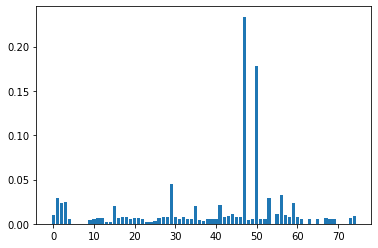

In [ ]:
pyplot.bar(range(len(impts_model.feature_importances_)), impts_model.feature_importances_)
pyplot.show()

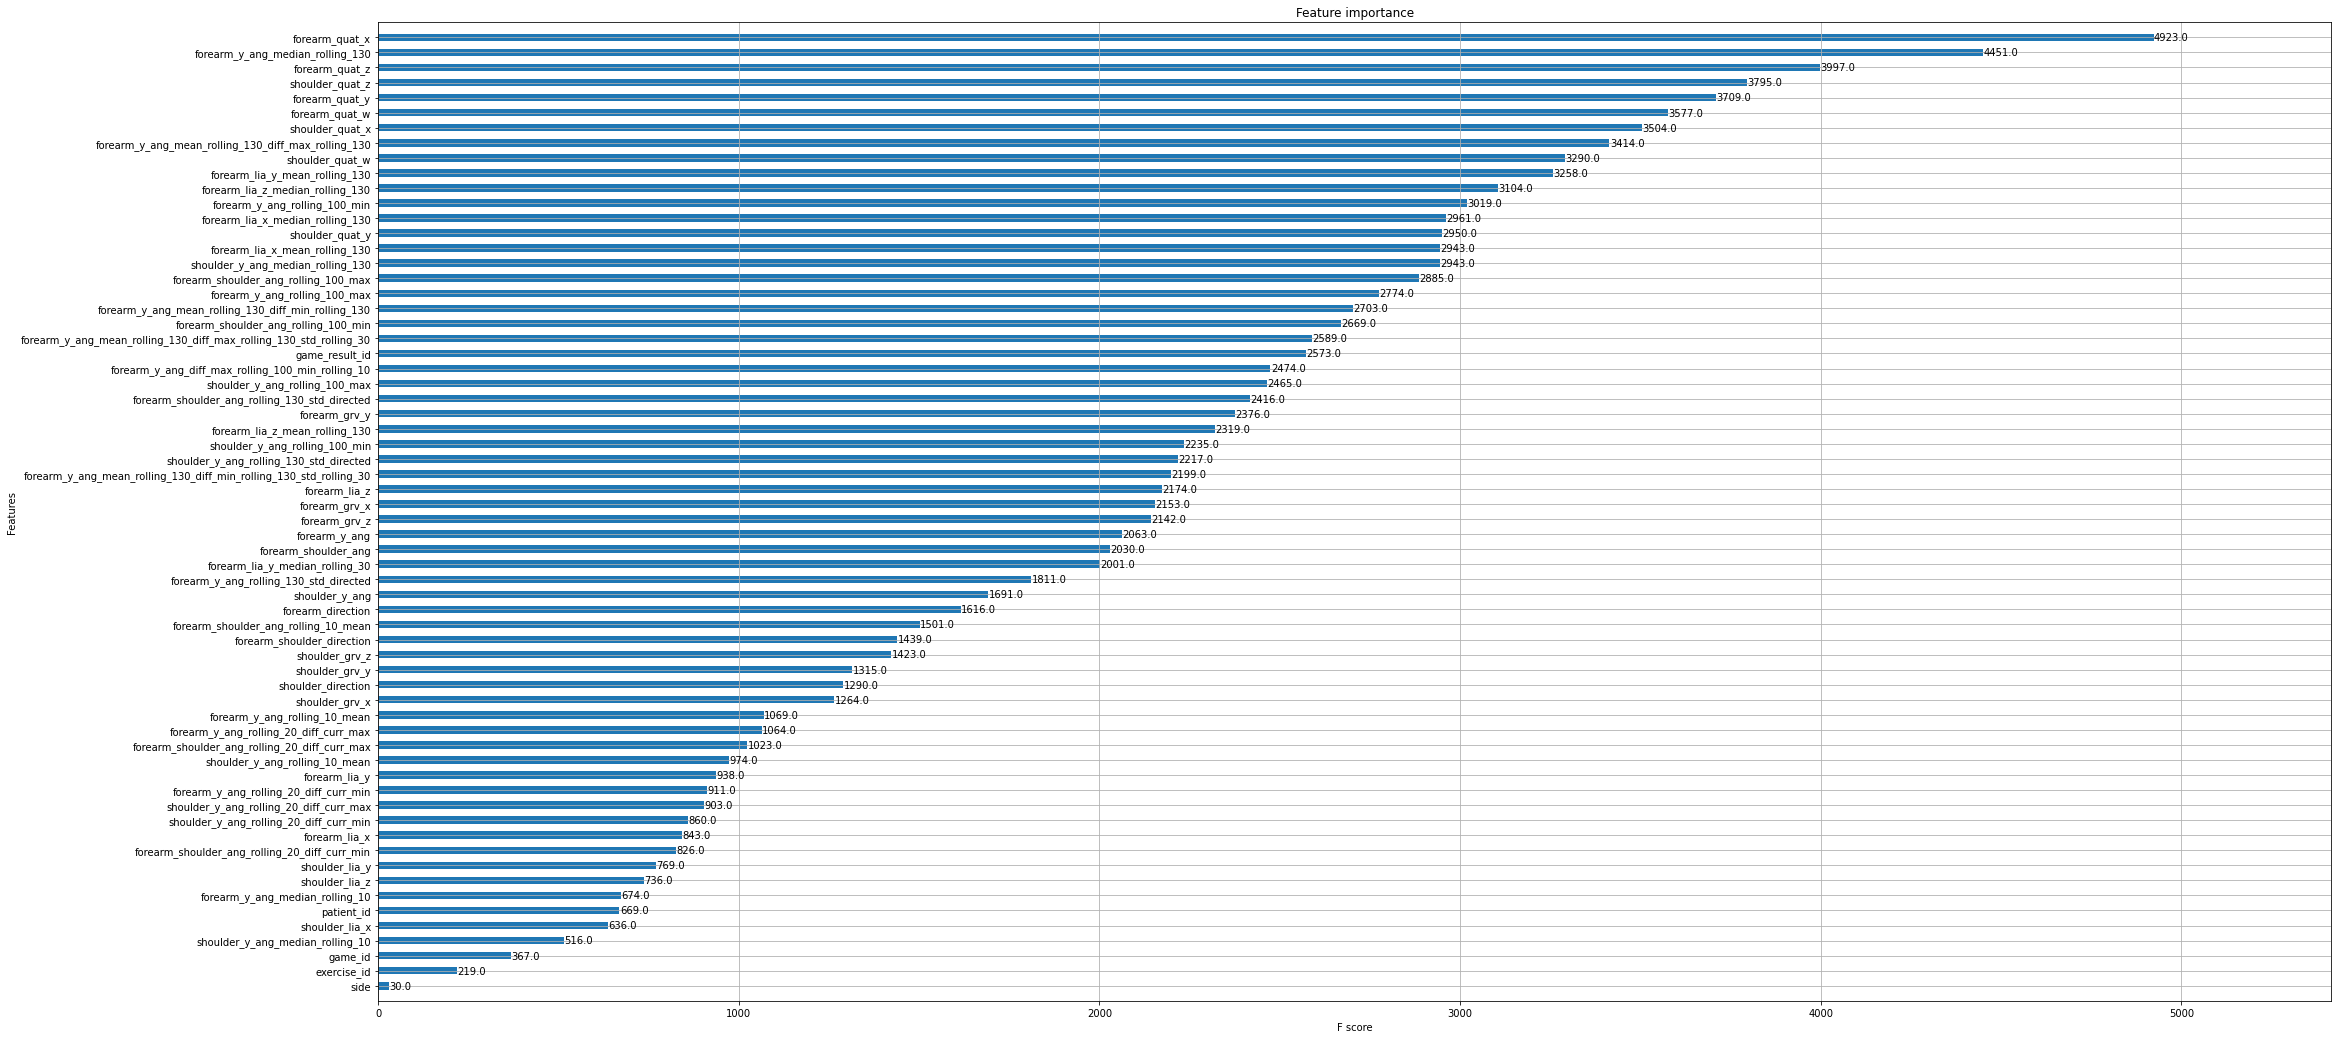

In [ ]:
from xgboost import plot_importance

ax = plot_importance(impts_model, height=0.5)
fig = ax.figure
fig.set_size_inches(35, 18)
pyplot.show()

In [145]:
# X_test['pred'] = y_pred
# X_test.head()

In [146]:
def plot_prediction(result_id, feature_name):
    result_df = X_test.loc[df['game_result_id'] == result_id].reset_index(drop=True)

    assert len(exercise_ids := result_df['exercise_id'].unique()) == 1
    assert len(patient_ids := result_df['patient_id'].unique()) == 1
    assert len(game_ids := result_df['game_id'].unique()) == 1
    exercise_id = exercise_ids[0]
    patient_id = patient_ids[0]
    game_id = game_ids[0]

    # 'ArrowDown' positionType = 1;
    start_mark_locs = result_df.loc[result_df['pred'] == 1].index
    # 'ArrowUp' positionType = 2;
    end_mark_locs = result_df.loc[result_df['pred'] == 2].index    

    result_df[feature_name].plot(
        title=f'feature: {feature_name}, patient: {patient_id}, result: {result_id}',
        figsize=(25, 6),
        color='tab:blue',
        marker='o',
        markeredgewidth=0,
        markersize=5,
        markerfacecolor='black',
        markevery=start_mark_locs,
    )
    result_df[feature_name].plot(
        figsize=(25, 6),
        color='tab:blue',
        marker='o',
        markeredgewidth=0,
        markersize=5,
        markerfacecolor='red',
        markevery=end_mark_locs,
    )
    plt.figure()

In [ ]:
# for result_id in sorted(test_result_ids):
#     plot_prediction(result_id,'forearm_y_ang')

In [ ]:
print(f"Accuracy {accuracy_score(y_test, y_pred) * 100}%")

Accuracy 80.0233230921038%
